In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import scipy.io as sp_io
from scipy import stats

import bct
import bct_duzc

import warnings
warnings.filterwarnings("ignore")

In [2]:
example_rewired_connectomes = sp_io.loadmat("./data/example_rewired_connectomes.mat")['example_rewired_connectomes']
coordinates = sp_io.loadmat("./data/dk_coordinates.mat")['coordinates']

# Weighted to binary network

In [3]:
n_sub = example_rewired_connectomes.shape[0]
n_node = example_rewired_connectomes.shape[1]
n_edge = n_node * (n_node - 1) // 2
thr = 27
n_sub, n_node, n_edge, thr

(270, 68, 2278, 27)

In [4]:
density = []
binarised_connectomes = []
for i in range(n_sub):
    W_thr = example_rewired_connectomes[i, :, :].copy()
    W_thr[W_thr<thr] = 0
    density.append( (np.triu(W_thr, 1) > 0).sum() / n_edge )
    B = np.zeros(W_thr.shape)
    B[W_thr>0] = 1
    binarised_connectomes.append(B)

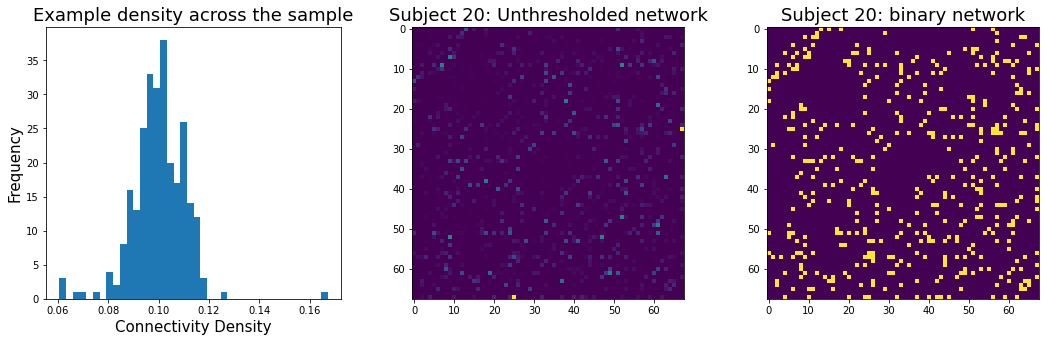

In [5]:
subVis = 20
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(density, bins=40)
plt.xlabel('Connectivity Density', size=15)
plt.ylabel('Frequency', size=15)
plt.title('Example density across the sample', size=18)

plt.subplot(1, 3, 2)
plt.imshow(example_rewired_connectomes[subVis, :, :])
plt.title(f'Subject {subVis}: Unthresholded network', size=18)

plt.subplot(1, 3, 3)
plt.imshow(binarised_connectomes[subVis])
plt.title(f'Subject {subVis}: binary network', size=18)

plt.show()
plt.close()

# Generate seed network

In [6]:
proportion = 0.2
Atgt_set = np.array(binarised_connectomes)
connections = Atgt_set.mean(axis=0)
A = np.zeros(connections.shape)
A[connections==proportion] = 1

In [7]:
degree = (A>0).sum(axis=0)

In [8]:
nz = (Atgt_set.sum(axis=(1, 2)) // 2).astype(int)

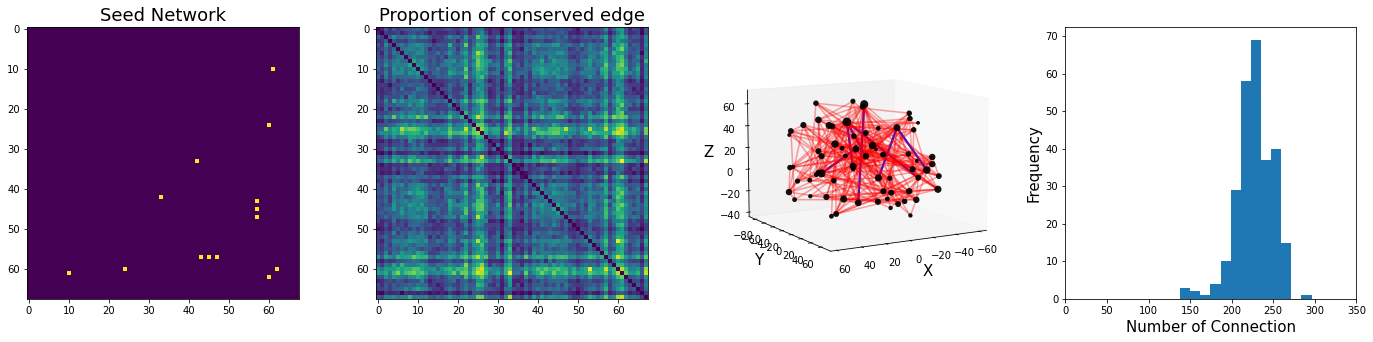

In [9]:
plt.figure(figsize=(24, 5))

plt.subplot(1, 4, 1)
plt.imshow(A)
plt.title('Seed Network', size=18)

plt.subplot(1, 4, 2)
plt.imshow(connections)
plt.title('Proportion of conserved edge', size=18)

ax = plt.subplot(1, 4, 3, projection='3d')
subVis = 120
sub_network = binarised_connectomes[subVis]
sub_degree = (sub_network>0).sum(axis=0).reshape((-1, 1))
sub_edge = np.array([ (coordinates[u], coordinates[v]) for u, v in np.argwhere(sub_network) ])
init_edge = np.array([ (coordinates[u], coordinates[v]) for u, v in np.argwhere(A) ])

ax.grid(False)
ax.view_init(elev=10, azim=60)
ax.scatter(*coordinates.T, s=sub_degree*3+2, c='black', alpha=0.9)
for edge in init_edge:
    ax.plot(*edge.T, color="blue", alpha=0.75, lw=2)
for edge in sub_edge:
    ax.plot(*edge.T, color="red", alpha=0.2)
ax.set_xlabel('X', size=15)
ax.set_ylabel('Y', size=15)
ax.set_zlabel('Z', size=15)

plt.subplot(1, 4, 4)
plt.hist(nz, bins=20)
plt.xlim(0, 350)
plt.xlabel("Number of Connection", size=15)
plt.ylabel("Frequency", size=15)

plt.show()
plt.close()

# Run generative model

In [10]:
import scipy.spatial as sp_spatial

In [11]:
D = sp_spatial.distance.squareform(sp_spatial.distance.pdist(coordinates, metric="euclidean"))
model_type = ['euclidean', 'neighbors', 'matching', 
             'clu-avg', 'clu-min', 'clu-max', 'clu-diff', 'clu-prod',
             'deg-avg', 'deg-min', 'deg-max', 'deg-diff', 'deg-prod']
model_var  = ['powerlaw', 'powerlaw']

eta_limits = [-7, 7] 
gam_limits = [-7, 7]
n_run = 64
eta = np.linspace(eta_limits[0], eta_limits[1], num=np.sqrt(n_run).astype(int) )
gam = np.linspace(gam_limits[0], gam_limits[1], num=np.sqrt(n_run).astype(int) )
p, q = np.meshgrid(eta, gam)
params = np.array([p.ravel(), q.ravel()]).T
n_params = params.shape[0]

In [12]:
def calc_ks_stat(t1, t2):
    bin_edges = np.concatenate( ([-np.Inf], np.sort(np.concatenate([t1, t2])), [np.Inf]) )
    bin_x, _ = np.histogram(t1, bin_edges)
    bin_y, _ = np.histogram(t2, bin_edges)
    sum_x = bin_x.cumsum()/bin_x.sum()
    sum_y = bin_y.cumsum()/bin_y.sum()
    return np.abs(sum_x[:-1] - sum_y[:-1]).max()

def synth_network_dat_iter(dat):
    for i in range(dat.shape[-1]):
        yield dat[:, :, i]

synth_all, K_all, E_all = {}, {}, {}
for i in range(2):
    synth_all[i], K_all[i], E_all[i] = [], [], []
    
    Atgt = binarised_connectomes[i]
    m = nz[i]
    n = Atgt.shape[0]
    x = [Atgt.sum(axis=1), 
         bct.clustering_coef_bu(Atgt), 
         bct.betweenness_bin(Atgt), 
         D[np.triu(Atgt, k=1).astype(bool)] ]
    np.disp(f"running generative model for subject {i}")
    
    for mt in model_type:
        B = bct_duzc.generative_model(A.copy(), D, m, eta=params[:, 0], gamma=params[:, 1], model_type=mt, model_var=model_var[0]) # 返回值是各种参数下生成的网络
        KS_stat = []
        for b in synth_network_dat_iter(B):
            y = [b.sum(axis=1),
                 bct.clustering_coef_bu(b),
                 bct.betweenness_bin(b), 
                 D[np.triu(b, k=1).astype(bool)] ]
            KS_stat.append( [ calc_ks_stat(t1, t2)   for t1, t2 in zip(x, y) ])
        
        synth_all[i].append(B)
        KS_stat = np.array(KS_stat)
        K_all[i].append( KS_stat )
        E_all[i].append( KS_stat.max(axis=1) )
        #break
    #break

running generative model for subject 0
running generative model for subject 1


# Exploring Generative model outputs

In [13]:
generative10000_energy = sp_io.loadmat("./data/generative10000_energy.mat")["generative10000_energy"]
generative10000_parameters = sp_io.loadmat("./data/generative10000_parameters.mat")["generative10000_parameters"]
generative50000_energy = sp_io.loadmat("./data/generative50000_energy.mat")['generative50000_energy']
generative50000_ks = sp_io.loadmat("./data/generative50000_ks.mat")['generative50000_ks']
generative50000_parameters = sp_io.loadmat("./data/generative50000_parameters.mat")['generative50000_parameters']

In [14]:
generative10000_energy.shape, generative10000_parameters.shape, generative50000_energy.shape, generative50000_ks.shape, generative50000_parameters.shape

((270, 13, 10000),
 (270, 13, 10000, 2),
 (270, 50040),
 (270, 50040, 4),
 (270, 50040, 2))

## Supplymentary Table 1

In [15]:
e = generative10000_energy[:, :, 0]
p1 = generative10000_parameters[:, :, 0, 0]
p2 = generative10000_parameters[:, :, 0, 1]

In [16]:
networktable = pd.DataFrame([ model_type, e.mean(axis=0), e.std(axis=0), p1.mean(axis=0), p1.std(axis=0), p2.mean(axis=0), p2.std(axis=0)]).T
networktable.columns = ['Rule', 'Mean E', 'Std E', 'Mean eta', 'Std eta', 'Mean gamma', 'Std gamma']
np.disp(networktable)

         Rule    Mean E     Std E  Mean eta   Std eta Mean gamma Std gamma
0   euclidean   0.33759  0.020029 -3.939693   0.39702   0.349345  3.939998
1   neighbors  0.165417  0.020349 -1.994463  0.483067   0.338346  0.045446
2    matching  0.141124  0.021211 -1.647213  0.490332   0.357202  0.022473
3     clu-avg  0.181125   0.01585 -3.070258  0.377984  -6.202843  0.734831
4     clu-min  0.251576  0.020497 -3.625963  0.395571  -6.130565  0.795413
5     clu-max  0.182379  0.014494 -3.094875  0.387177  -6.152563  0.735212
6    clu-diff  0.322193  0.025279 -6.192892  0.744218  -3.479835  2.017705
7    clu-prod  0.223433  0.023637 -3.400748  0.393151   -5.96401  0.926008
8     deg-avg  0.220993  0.018657 -3.515975   0.50215   2.419229  0.332469
9     deg-min   0.27872  0.015885  -4.74942  0.749037   0.473999  0.099651
10    deg-max  0.215844  0.019247 -3.556828  0.602143   2.255294  0.332067
11   deg-diff  0.229222  0.017859  -3.83599  0.669029   1.689113   0.57685
12   deg-prod  0.276768  

## Supplymentary Figure 2

In [17]:
eta_std = generative10000_parameters[:, :, :500, 0].mean(axis=2).std(axis=0)
gam_std = generative10000_parameters[:, :, :500, 1].mean(axis=2).std(axis=0)

No handles with labels found to put in legend.


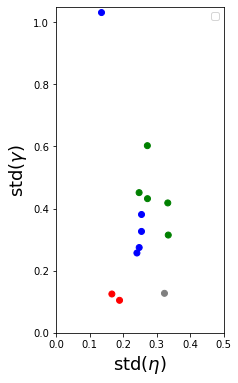

In [18]:
plt.figure(figsize=(3, 6))
plt.scatter(eta_std, gam_std, c = ['gray'] + ['red']*2 + ['blue']*5 + ['green'] * 5)
plt.xlim(0, 0.5)
plt.ylim(0, 1.05)
plt.xlabel('std$(\eta)$', size=18)
plt.ylabel('std$(\gamma)$', size=18)
plt.legend()
plt.show()
plt.close()

## Supplymentary Table 2

In [19]:
top_n_performance = []
for n in [1, 10, 100, 500]:
    if n == 1:
        p1 = generative50000_parameters[:, :n, 0]
        p2 = generative50000_parameters[:, :n, 1]
    
    top_n_performance.append( [generative50000_energy[:, :n].mean(), generative50000_energy[:, :n].std(), 
                               generative50000_parameters[:, :n, 0].mean(), generative50000_parameters[:, :n, 0].std(),
                               generative50000_parameters[:, :n, 1].mean(), generative50000_parameters[:, :n, 1].std()])
top_n_performance =  pd.DataFrame(top_n_performance)
top_n_performance.index = ['top 1', 'top 10', 'top 100', 'top 500']
top_n_performance.columns = ['Mean E', 'Std E', 'Mean eta', 'Std eta', 'Mean gamma', 'Std gamma']
np.disp(top_n_performance)

           Mean E     Std E  Mean eta   Std eta  Mean gamma  Std gamma
top 1    0.090248  0.010016 -1.565240  0.326255    0.349433   0.033435
top 10   0.100560  0.011369 -1.579087  0.334360    0.351653   0.036024
top 100  0.116309  0.013162 -1.613879  0.371681    0.354629   0.037954
top 500  0.132604  0.015441 -1.657792  0.427422    0.357027   0.040192


## Figure 2

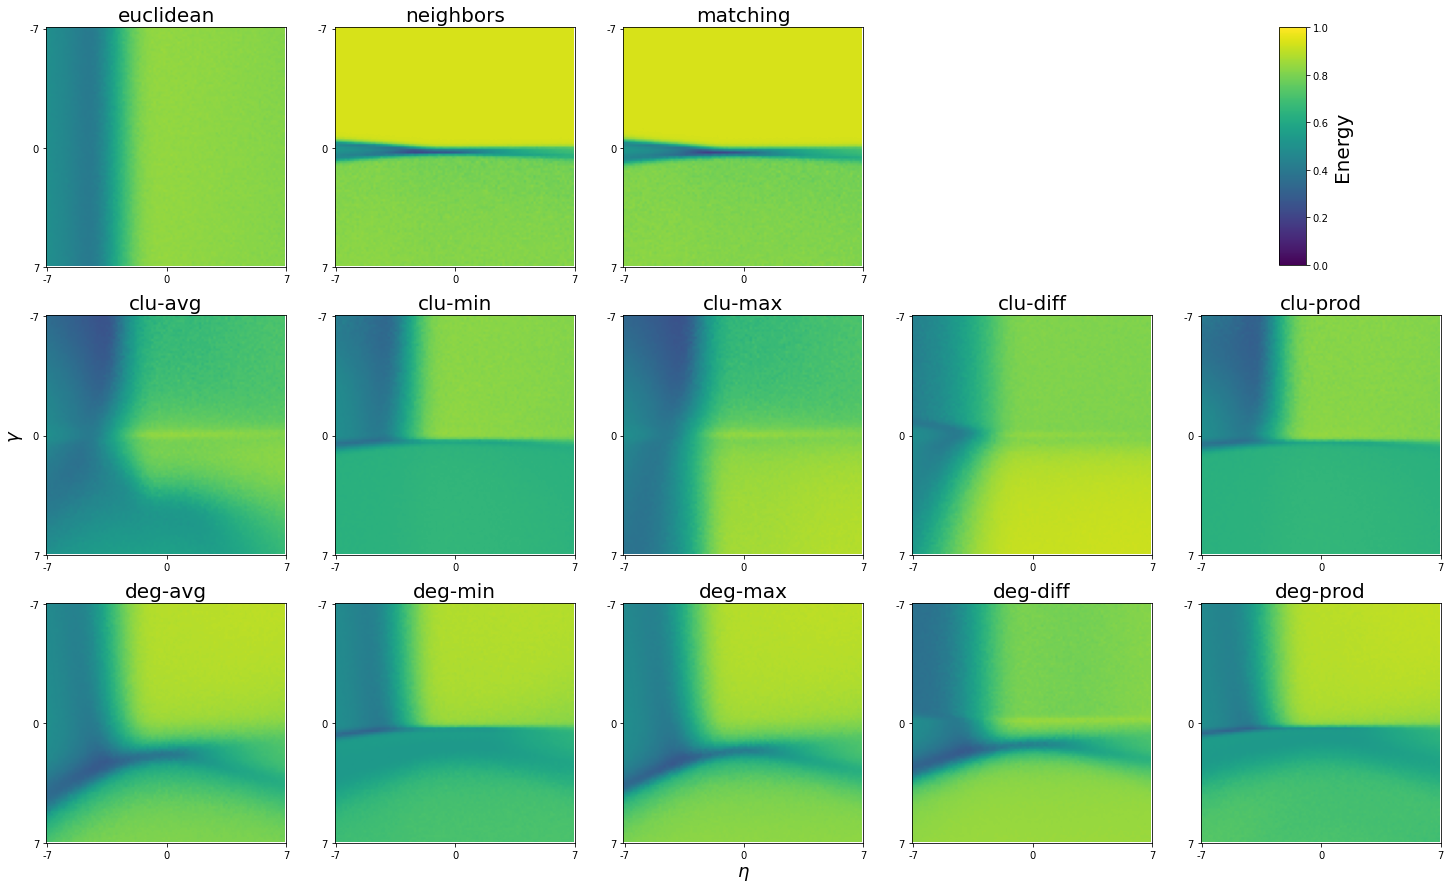

In [20]:
# Fig 2 a-d
plt.figure(figsize=(25, 15))
for m, mt in enumerate(model_type):
    energy_landscape = 0
    for sub in range(n_sub):
        subj_energy = generative10000_energy[sub, m, :]
        subj_params = generative10000_parameters[sub, m, :, :]
        u, idx = np.unique(subj_params, return_index=True, axis=0)
        uniq_eta = np.unique(u[:, 0]).shape[0]
        uniq_gam = np.unique(u[:, 1]).shape[0]
        
        energy_landscape += subj_energy[idx, ].reshape((uniq_eta, uniq_gam)).T
        #break
    energy_landscape /= n_sub
    
    if m < 3:
        plot_loc = m+1
    else:
        plot_loc = m+3
    plt.subplot(3, 5, plot_loc)
    plt.imshow(energy_landscape, vmin=0, vmax=1)
    if plot_loc == 6:
        plt.ylabel("$\gamma$", size=18)
    elif plot_loc == 13:
        plt.xlabel("$\eta$", size=18)
    plt.xticks(ticks=[0, 50, 100], labels=[-7, 0, 7], size=10)
    plt.yticks(ticks=[0, 50, 100], labels=[-7, 0, 7], size=10)
    plt.title(mt, size=20)
  
plt.subplot(3, 5, 5)
plt.axis(False)
cbar = plt.colorbar(cax=plt.axes([0.81, 0.66, 0.015, 0.22]))
cbar.set_label("Energy", size=20)
plt.show()
plt.close()

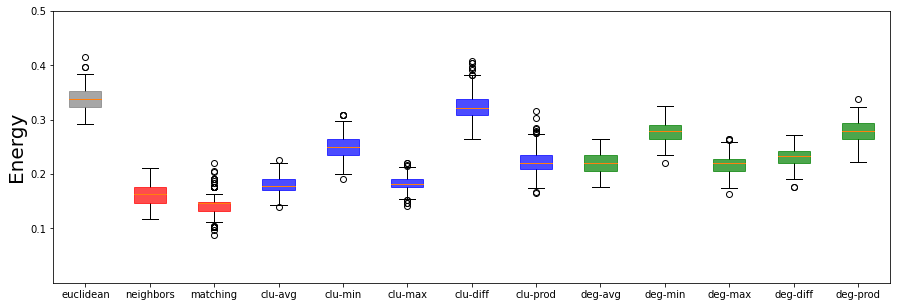

In [21]:
# Fig2 e
color = ['gray'] + ['red']*2 + ['blue']*5 + ['green'] * 5
plt.figure(figsize=(15, 5))
bp = plt.boxplot(e, patch_artist=True)
for i, c in enumerate(color):
    bp['boxes'][i].set(alpha=0.7, color=color[i])

plt.xticks(np.arange(1, 14), model_type)
plt.ylim(0, 0.5)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5 ], [0.1, 0.2, 0.3, 0.4, 0.5 ])
plt.ylabel("Energy", size=20)
plt.show()
plt.close()

In [22]:
energy_landscape = 0
ks_landscape = [0, 0, 0, 0]
for sub in range(n_sub):
    subj_energy = generative50000_energy[sub, :]
    subj_params = generative50000_parameters[sub, :, :]
    subj_ks     = generative50000_ks[sub, :, :]
    u, idx = np.unique(subj_params, return_index=True, axis=0)
    uniq_eta = np.unique(u[:, 0]).shape[0]  # 417
    uniq_gam = np.unique(u[:, 1]).shape[0]  # 417
    
    energy_landscape += subj_energy[idx].reshape((uniq_eta, uniq_gam)).T
    for i in range(len(ks_landscape)):
        ks_landscape[i] += subj_ks[idx, i].reshape((uniq_eta, uniq_gam)).T
energy_landscape /= n_sub
for i in range(len(ks_landscape)):
    ks_landscape[i] /= n_sub

params_min, params_max = u.min(axis=0), u.max(axis=0)
k = [416, -119] / (params_max - params_min)
b = np.array([0, 119]) - k*params_min

p1_scale = p1 * k[0] + b[0]
p2_scale = p2 * k[1] + b[1]

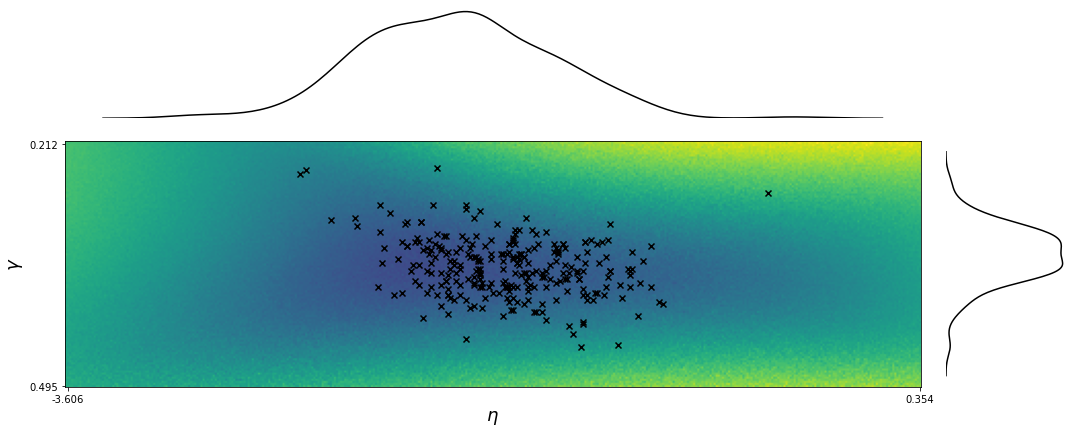

In [23]:
## fig 2f
plt.figure(figsize=(18, 7))
plt.subplot2grid((3, 7), (0, 0), rowspan=1, colspan=6)
plt.axis(False)
sns.kdeplot(np.squeeze(p1_scale), shade=False, color='black')
plt.plot()

plt.subplot2grid((3, 7), (1, 0), rowspan=2, colspan=6)
plt.imshow(energy_landscape, vmin=0.1, vmax=0.5)
plt.xticks([1, 416], [-3.606, 0.354])
plt.yticks([1, 119], [0.212, 0.495])
plt.ylabel("$\gamma$", size=18)
plt.xlabel("$\eta$", size=18)
plt.scatter(p1_scale, p2_scale, marker='x', c='black')


plt.subplot2grid((3, 7), (1, 6), rowspan=2, colspan=1)
sns.kdeplot(np.squeeze(p2_scale), shade=False, color='black', vertical=True)
plt.axis(False)
plt.plot()

plt.show()
plt.close()

## Supplymentary Figure 3

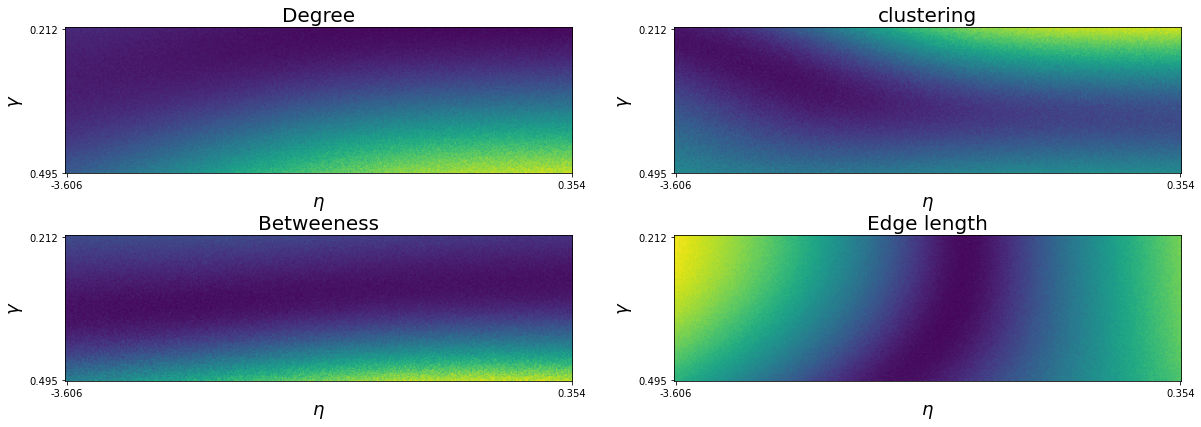

In [24]:
## SFig a-d
plt.figure(figsize=(20, 7))
for i, title in enumerate(['Degree', 'clustering', 'Betweeness', 'Edge length']):
    plt.subplot(2, 2, i+1)
    plt.imshow(ks_landscape[i])
    plt.xticks([1, 416], [-3.606, 0.354])
    plt.yticks([1, 119], [0.212, 0.495])
    plt.ylabel("$\gamma$", size=18)
    plt.xlabel("$\eta$", size=18)
    plt.title(title, size=20)
    
plt.show()
plt.close()

In [25]:
tmp = generative50000_ks.argmax(axis=2)
ratio = np.bincount(tmp.flat)/tmp.size
max_enregy_dist = pd.DataFrame(tmp).apply(np.bincount, axis=1, result_type='expand').to_numpy()

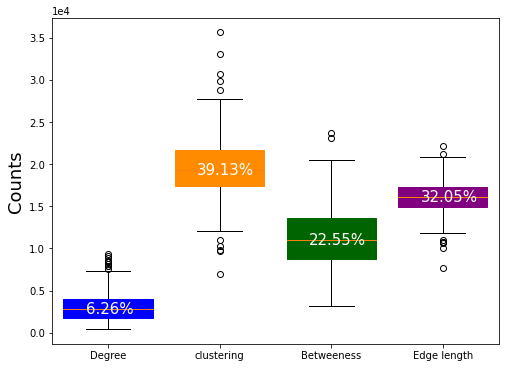

In [26]:
## SFig e
plt.figure(figsize=(8, 6))
bp = plt.boxplot(max_enregy_dist, patch_artist=True, widths=0.80)
for i, c in enumerate(['blue', 'darkorange', 'darkgreen', 'purple']):
    bp['boxes'][i].set(color=c)
for x, y, s in zip(np.array([1, 2, 3, 4])-0.2, np.median(max_enregy_dist, axis=0)-500,[ format(i, '4.2%') for i in ratio] ):
    plt.text(x, y, s, c='white', size=15)

plt.xticks([1, 2, 3, 4], ['Degree', 'clustering', 'Betweeness', 'Edge length'], c='black')
plt.ylabel('Counts', size=18)
plt.ticklabel_format(axis='y', style='sci', scilimits=(10000, 40000))
plt.show()
plt.close()

In [27]:
## SFig 3f

p1_mean, p2_mean = [], []
pearson_r = []
for n in [1, 10, 100, 500]:
    p1 = generative50000_parameters[:, :n, 0].mean(axis=1)
    p2 = generative50000_parameters[:, :n, 1].mean(axis=1)
    r, pval = stats.pearsonr(p1, p2)
    p1_mean.append(p1)
    p2_mean.append(p2)
    pearson_r.append(f"top {n:3.0f}: R={r:e}, P = {pval:e}")
    #break

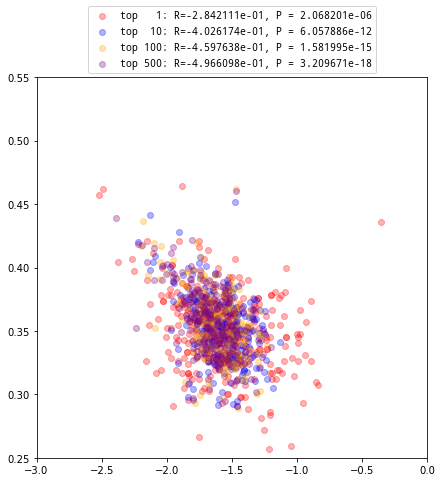

In [29]:
## SFig 3f
color = ['red', 'blue', 'orange', 'purple']
plt.figure(figsize=(7, 7))
for n, (p1, p2) in enumerate(zip(p1_mean, p2_mean)):
    plt.scatter(p1, p2, c=color[n], label=pearson_r[n], alpha=0.3)
plt.legend(fontsize=15, prop={'family':'Noto Mono'},  bbox_to_anchor=(0.5, 1.01), loc=8, borderaxespad=0)
plt.xlim(-3, 0)
plt.ylim(0.25, 0.55)
plt.show()
plt.close()

# Homophily generative model

In [145]:
example_binarised_connectomes = sp_io.loadmat("./data/example_binarised_connectomes.mat")['example_binarised_connectomes']
euclidean = sp_io.loadmat("./data/example_euclidean.mat")['euclidean']

eta, gam = -1.5, 0.25
params = np.array([[eta, gam]])
n_sub = 270

matching_K = []
matching_Fk = []
matching_Ksum = []
matching_Fksum = []
matching_P = []
matching_Psum = []
matching_A = []

In [137]:
for sub in range(n_sub):
    Atgt_set = example_binarised_connectomes
    proportion = 0.2
    connections = Atgt_set.mean(axis=0)
    A = np.zeros(connections.shape)
    A[connections == proportion] = 1
    D = euclidean
    
    Atgt = Atgt_set[sub, :, :]
    params = params
    m = int(Atgt.sum()//2)
    model_var = 'powerlaw'
    epsilon = 10**(-5)
    
    n = len(D)
    mseed = int(A.sum()//2)
    nparams = params.shape[0]
    b = np.zeros((m, nparams))
    K = bct.matching_ind(A)[-1]
    
    Kall, Fkall, Pall, Aall = [], [], [], []
    Kall.append(K)
    Aall.append(A)
    for iparam in range(nparams):
        eta, gam = params[iparam, :]
        K += epsilon
        
        Fd = D**eta
        Fk = K**gam
        Ff = Fd * Fk * (1-A)
        
        u, v = np.argwhere(np.triu(np.ones((n, n)), 1)).T
        P = Ff[u, v]
        Fkall.append(Fk)
        Ff[np.isinf(Ff)] = 0
        Pall.append(Ff)
        step = 2
        for ii in range(mseed, m):
            C = np.append( 0, P.cumsum() )
            r = (np.random.random() * C[-1] >= C).sum() - 1
            uu, vv = u[r], v[r]
            A[uu, vv] = A[vv, uu] = 1
            
            updateuu = np.where( np.inner(A, A[:, uu]) )[0]
            updateuu = updateuu[np.isin(updateuu, [uu, vv])]
            c1 = np.append(A[:, uu], A[:, uu])
            for i in range(len(updateuu)):
                j = updateuu[i]
                c2 = np.append(A[:, j], A[:, j])
                use = use = np.logical_or(c1, c2)
                use[uu] = use[uu+n] = use[j] = use[j+n] = 0
                ncon = c1[use].sum() + c2[use].sum()
                if ncon == 0:
                    K[uu, j] = K[j, uu] = epsilon
                else:
                    K[uu, j] = K[j, uu] = (2 * (np.logical_and(c1[use], c2[use]).sum()/ncon)) + epsilon
            
            updatevv = np.where(np.inner(A, A[:,vv]))[0]
            updatevv = updatevv[np.isin(updatevv, [uu, vv])]
            c1 = np.append(A[:,vv], A[vv,:])
            for i in range(len(updatevv)):
                j = updatevv[i]
                c2 = np.append(A[:,j], A[j,:])
    
                use = np.logical_or(c1, c2)
                use[vv] = use[vv+n] = use[j] = use[j+n] = 0
                ncon = np.sum(c1[use]) + np.sum(c2[use])
                if ncon == 0:
                    K[vv, j] = K[j, vv] = epsilon
                else:
                    K[vv, j] = K[j, vv] = (2 * (np.logical_and(c1[use], c2[use]).sum()/ncon)) + epsilon
                    
            
            Fk = K**gam
            Kall.append(K)
            Fkall.append(Fk)
            Aall.append(A)
            
            Ff = Fd * Fk * (1-A)
            P = Ff[u, v]
            Ff[np.isinf(Ff)] = 0
            Pall.append(Ff)
            step += 1
        b
        matching_K.append(np.array(Kall))
        matching_Ksum.append( np.array(Kall).sum(axis=1))
        matching_Fk.append(np.array(Fkall))
        matching_Fk.append(np.array(Fkall).axis(axis=1))
        matching_P.append(np.array(Pall))
        matching_Psum.append(np.array(Pall).sum(axis=0))
        
        break
    break

# Embedding, errors and predictions

In [164]:
example_binarised_connectomes = sp_io.loadmat("./data/example_binarised_connectomes.mat")['example_binarised_connectomes']
example_optimised_simulations = sp_io.loadmat("./data/example_optimised_simulations.mat")['example_optimised_simulations']
euclidean = sp_io.loadmat("./data/example_euclidean.mat")['euclidean']
generative50000_parameters = sp_io.loadmat("./data/generative50000_parameters.mat")['generative50000_parameters']

In [292]:
def calc_local_statistics(connectome, D):
    return [bct.degrees_und(connectome), 
            bct.betweenness_bin(connectome),
            bct.clustering_coef_bu(connectome),
            (D*(np.triu(connectome, 1)>0)).sum(axis=1),
            bct.efficiency_bin(connectome, local=True)]
def calc_global_statistics(connectome):
    return [np.nanmax(bct.rich_club_bu(connectome)[0]),
            bct.assortativity_bin(connectome, 0),
            bct.transitivity_bu(connectome),
            bct.modularity_und(connectome)[1]]

n_sub = 270

observed_local_statistics = []
observed_global_statistics = []
simulated_local_statistics = []
simulated_global_statistics = []
for sub in range(n_sub):
    obs = example_binarised_connectomes[sub, :, :]
    observed_local_statistics.append(calc_local_statistics(obs, euclidean))
    observed_global_statistics.append(calc_global_statistics(obs))
    
    sti = example_optimised_simulations[sub, :, :]
    simulated_local_statistics.append(calc_local_statistics(sti, euclidean))
    simulated_global_statistics.append(calc_global_statistics(sti))

## Figure 3, and Supplymentary Figure 4

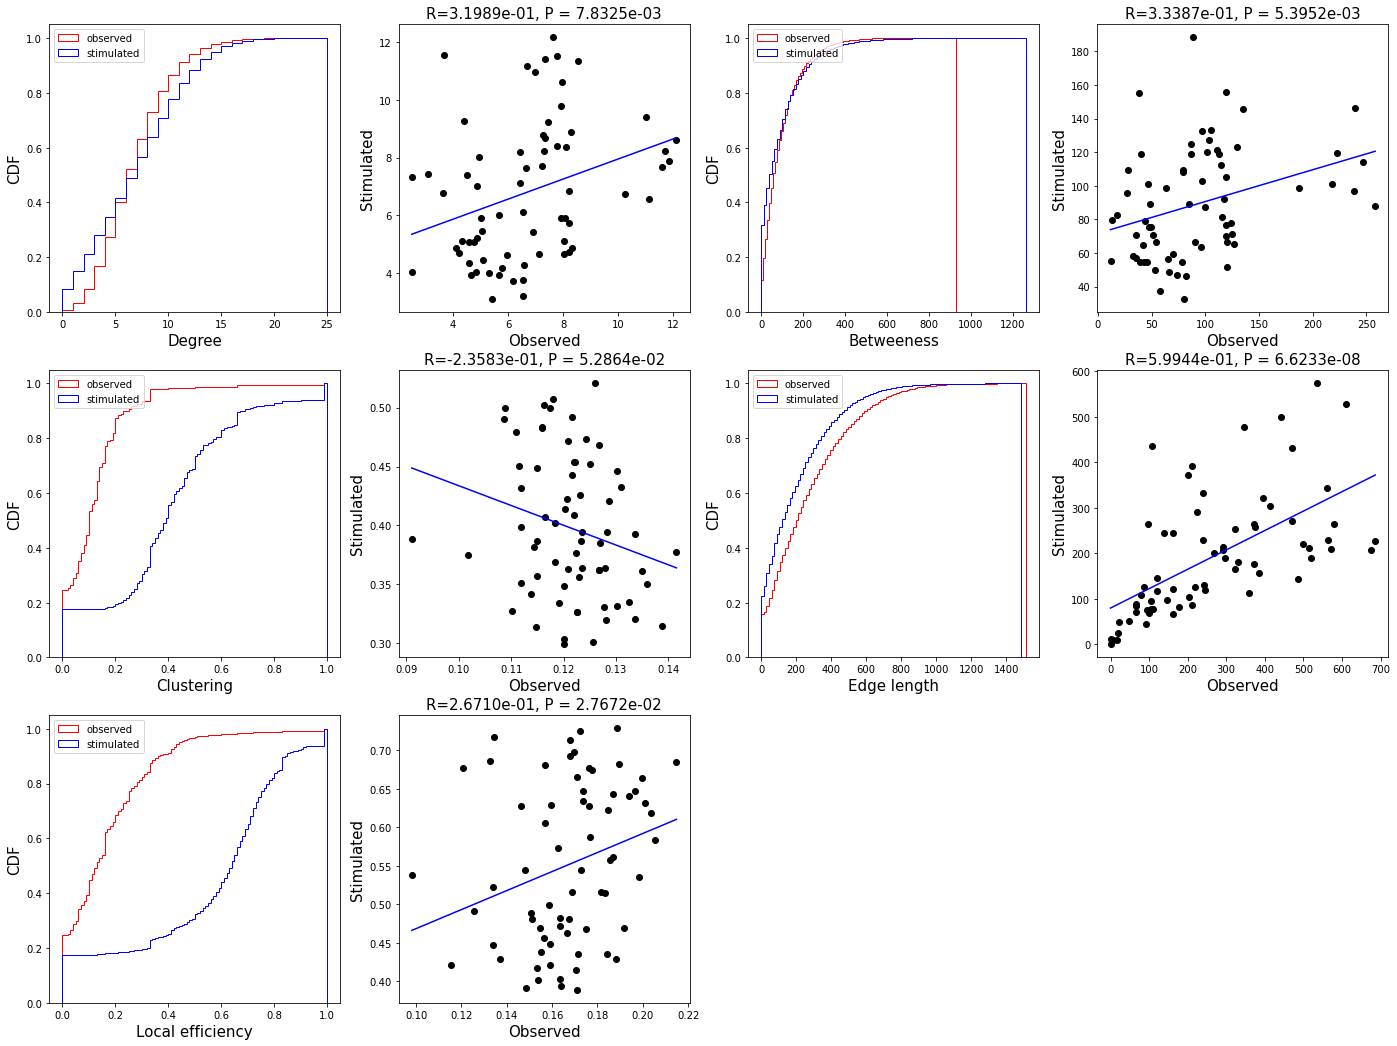

In [273]:
# Figure 3, SFigure 4a

plt.figure(figsize=(24, 18))
k = 0
for i, measure in enumerate(['Degree', 'Betweeness', 'Clustering', 'Edge length', 'Local efficiency']):
    obs_measure = np.array([ observed_local_statistics[k][i] for k in range(n_sub) ])
    sti_measure = np.array([ simulated_local_statistics[k][i] for k in range(n_sub) ])
    # print(measure, obs_measure.shape)
    
    k += 1
    plt.subplot(3, 4, k)
    plt.hist(obs_measure.flat, cumulative=True, density=True, histtype='step', color='red', label='observed', bins=100)
    plt.hist(sti_measure.flat, cumulative=True, density=True, histtype='step', color='blue', label='stimulated', bins=100)
    plt.legend(loc=2)
    plt.xlabel(measure, size=15)
    plt.ylabel('CDF', size=15)
    
    k += 1
    plt.subplot(3, 4, k)
    x = obs_measure.mean(axis=0)
    y = sti_measure.mean(axis=0)
    r, pval = stats.pearsonr(x, y)
    param_fit = np.polyfit(x, y, deg=1)
    x_fit = np.array([x.min(), x.max()])
    y_fit = param_fit[0]*x_fit + param_fit[1]
    plt.plot(x_fit, y_fit, color='blue')
    plt.scatter(x, y, color='black')
    plt.title(f"R={r:.4e}, P = {pval:.4e}", size=15)
    plt.xlabel('Observed', size=15)
    plt.ylabel('Stimulated', size=15)

plt.show()
plt.close()

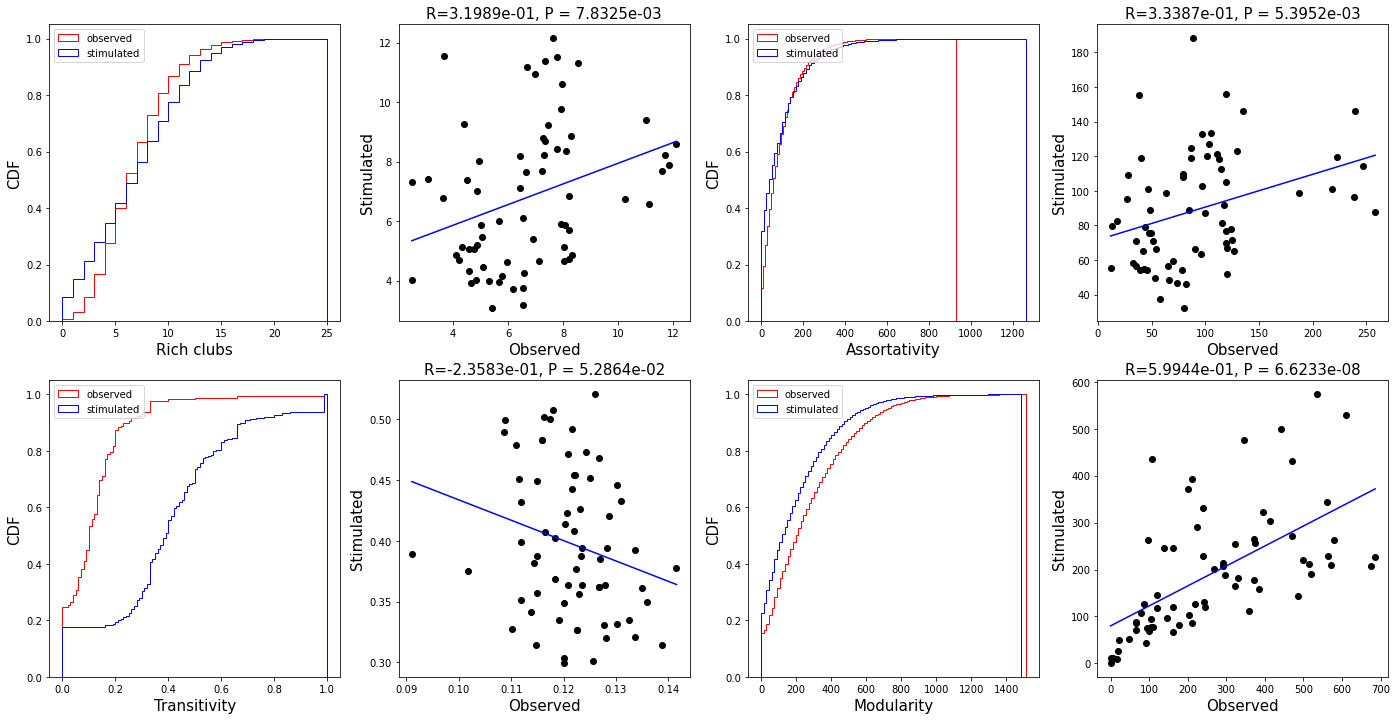

In [293]:
## SFigure 4b-d
plt.figure(figsize=(24, 12))
k = 0
for i, measure in enumerate(['Rich clubs','Assortativity','Transitivity','Modularity']):
    obs_measure = np.array([ observed_local_statistics[k][i] for k in range(n_sub) ])
    sti_measure = np.array([ simulated_local_statistics[k][i] for k in range(n_sub) ])
    # print(measure, obs_measure.shape)
    
    k += 1
    plt.subplot(2, 4, k)
    plt.hist(obs_measure.flat, cumulative=True, density=True, histtype='step', color='red', label='observed', bins=100)
    plt.hist(sti_measure.flat, cumulative=True, density=True, histtype='step', color='blue', label='stimulated', bins=100)
    plt.legend(loc=2)
    plt.xlabel(measure, size=15)
    plt.ylabel('CDF', size=15)
    
    k += 1
    plt.subplot(2, 4, k)
    x = obs_measure.mean(axis=0)
    y = sti_measure.mean(axis=0)
    r, pval = stats.pearsonr(x, y)
    param_fit = np.polyfit(x, y, deg=1)
    x_fit = np.array([x.min(), x.max()])
    y_fit = param_fit[0]*x_fit + param_fit[1]
    plt.plot(x_fit, y_fit, color='blue')
    plt.scatter(x, y, color='black')
    plt.title(f"R={r:.4e}, P = {pval:.4e}", size=15)
    plt.xlabel('Observed', size=15)
    plt.ylabel('Stimulated', size=15)

plt.show()
plt.close()

## Figure 4

In [350]:
observed_measure = np.append(np.array(observed_local_statistics).mean(axis=2), np.array(observed_global_statistics), axis=1)

heatmap_eta = []
heatmap_gam = []
for top_n in [1, 10, 100, 500]:
    params_set = generative50000_parameters[:, :top_n, :].mean(axis=1)
    r = np.corrcoef(params_set, observed_measure, rowvar=False)[:2, 2:]
    heatmap_eta.append(r[0, :])
    heatmap_gam.append(r[1, :])
heatmap_eta = np.array(heatmap_eta)
heatmap_gam = np.array(heatmap_gam)


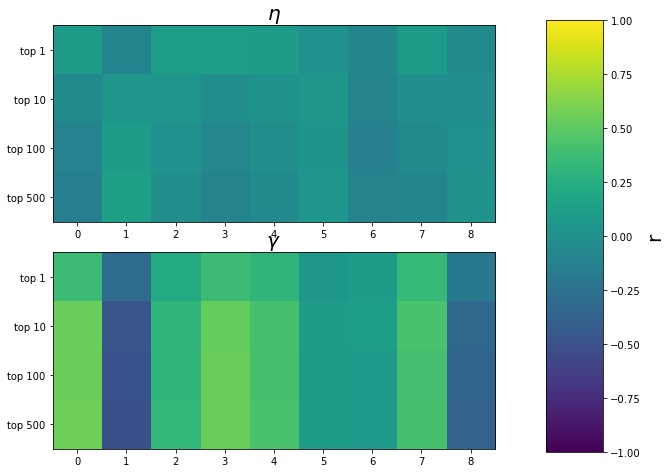

In [369]:
## figure 4a (right)
plt.figure(figsize=(10, 8))
plt.subplot2grid((4, 5), (0, 0), rowspan=2, colspan=4)
plt.imshow(heatmap_eta, vmin=-1, vmax=1)
plt.title('$\eta$', size=20)
plt.yticks([0, 1, 2, 3], ['top 1', 'top 10', 'top 100', 'top 500'])

plt.subplot2grid((4, 5), (2, 0), rowspan=2, colspan=4)
plt.imshow(heatmap_gam, vmin=-1, vmax=1)
plt.title('$\gamma$', size=20)
plt.yticks([0, 1, 2, 3], ['top 1', 'top 10', 'top 100', 'top 500'])

plt.subplot2grid((4, 5), (0, 4), rowspan=4, colspan=1)
plt.axis(False)
cbar = plt.colorbar(cax=plt.axes([0.81, 0.13, 0.08, 0.75]), )
cbar.set_label("r", size=20)

plt.show()
plt.close()

In [407]:
df = pd.DataFrame({
'group': ['eta','gamma'],
'1': [-0.1845,0.5947],
'2': [-0.6338,0.8285],
'3': [-0.1391,-0.4424],
'4': [0.4925,0.2491],
'5': [ -0.0460,0.4340],
'6': [0.0206,0.4001],
'7': [0.0531,-0.1602],
'8': [-0.5767,0.6689],
'9': [-0.2374,-0.2543],
'10': [-0.1627,0.2081],
'11': [-0.1799,0.2217],
'12': [-0.1979,0.1871],
'13': [-0.0296,-0.0179],
'14': [-0.1685, -0.0146],
'15': [-0.1259, 0.0222],
'16': [0.0012,-0.0861],
'17': [-0.1110,0.0519],
})

eta = df.iloc[0, 1:].values
eta = np.append(eta, eta[0])
gam = df.iloc[1, 1:].values
gam = np.append(gam, gam[0])
labels = np.array(df.columns[1:])
labels = np.append(labels, labels[0])
angles = np.linspace(0, 2*np.pi, df.shape[1], endpoint=True)


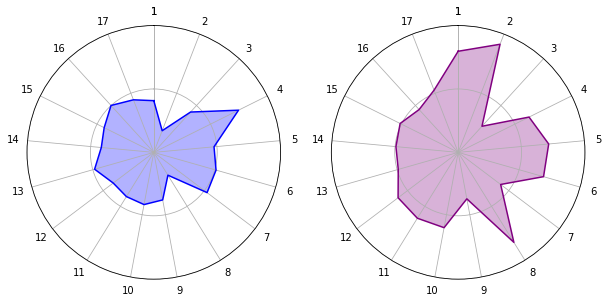

In [419]:
## Fig 4b (left)
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.plot(angles, eta, color='blue')
plt.fill(angles, eta, 'blue',alpha=0.3)
plt.xticks(angles, labels, color='black', size=10)
plt.yticks([-1, 0, 1], ["", "", ""])

ax = plt.subplot(1, 2, 2, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.plot(angles, gam, color='purple')
plt.xticks(angles, labels, color='black', size=10)
plt.fill(angles, gam, 'purple',alpha=0.3)
plt.yticks([-1, 0, 1], ["", "", ""])

plt.show()
plt.close()

# Gene Expression and PLS analysis

In [465]:
from sklearn.cross_decomposition import PLSRegression

In [456]:
matching_D_average = sp_io.loadmat('./data/matching_D_average.mat')['matching_D_average']
matching_Fksum_average = sp_io.loadmat('./data/matching_Fksum_average.mat')['matching_Fksum_average']
RNAgenenames = pd.read_table("./RNAgenenames.txt", header=None)[0].values
RNAgenematrix = sp_io.loadmat('./data/RNAgenematrix.mat')['RNAgenematrix']

In [457]:
## PLS hyper-parameters
X = RNAgenematrix
n_sub = 270
n_node = 34
n_comp = 6
n_perm = 1000 # permutation

In [519]:
pcorr_D = np.empty(shape=(n_sub, X.shape[1], n_comp))
for sub in range(n_sub):
    Y = matching_D_average[sub, 34:] # left-hemisphere only
    pls1 = PLSRegression(n_components=n_comp)
    pls1.fit(X, Y)
    
    X_loading_perm = []
    X_score_perm = []
    for permutation in range(n_perm):
        Y = Y[np.random.permutation(Y.shape[0])]
        pls2 = PLSRegression(n_components=n_comp)
        pls2.fit(X, Y)
        X_loading_perm.append(pls2.x_loadings_)
        X_score_perm.append(pls2.x_scores_)
    X_loading_perm = np.array(X_loading_perm)
    X_score_perm = np.array(X_score_perm)
    
    for comp in range(n_comp):
        null = X_loading_perm[:, :, comp]
        for gene in range(X.shape[1]):
            r = pls1.x_loadings_[gene, comp]
            z = null[:, gene]
            pcorr_D[sub, gene, comp] = (z>=r).mean()
    break

In [521]:
pcorr_Fk = np.empty(shape=(n_sub, X.shape[1], n_comp))
for sub in range(n_sub):
    Y = matching_Fksum_average[sub, 34:] # left-hemisphere only
    pls1 = PLSRegression(n_components=n_comp)
    pls1.fit(X, Y)
    
    X_loading_perm = []
    X_score_perm = []
    for permutation in range(n_perm):
        Y = Y[np.random.permutation(Y.shape[0])]
        pls2 = PLSRegression(n_components=n_comp)
        pls2.fit(X, Y)
        X_loading_perm.append(pls2.x_loadings_)
        X_score_perm.append(pls2.x_scores_)
    X_loading_perm = np.array(X_loading_perm)
    X_score_perm = np.array(X_score_perm)
    
    for comp in range(n_comp):
        null = X_loading_perm[:, :, comp]
        for gene in range(X.shape[1]):
            r = pls1.x_loadings_[gene, comp]
            z = null[:, gene]
            pcorr_Fk[sub, gene, comp] = (z>=r).mean()
    break